# Goal

## Questions

* How is incorporator identification accuracy affected by the percent isotope incorporation of taxa?
* How variable is sensitivity depending on model stochasticity
  * Each simulation has differing taxa as incorporators, therefore, the incorporators then differ by GC and abundance between simulations


## Method

* Using genome dataset created in the "dataset" notebook

* Simulates isotope dilution or short incubations
  * Method  
    * 25% taxa incorporate
    * incorporation % same for all incorporators
    * incorporation % treatments: 0, 5, 10, 25, 50
    * n-replicates = 10
    * Total treatments: 50

# User variables

In [8]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/'
buildDir = os.path.join(workDir, 'percIncorpUnifRep')
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# Init

In [9]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image, display

In [10]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [12]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)

# Creating input files (eg., fragments & communities)

## Simulating fragments

In [13]:
!cd $buildDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

## Converting to kde object

In [14]:
!cd $buildDir; \
    SIPSim fragment_kde \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Adding diffusion

In [15]:
!cd $buildDir; \
    SIPSim diffusion \
    ampFrags_kde.pkl \
    --np 24 \
    > ampFrags_kde_dif.pkl    

Processing: Vibrio_vulnificus_MO6-24_O
Processing: Dyella_japonica_A8
Processing: Citrobacter_koseri_ATCC_BAA-895
Processing: Leisingera_methylohalidivorans_DSM_14336
Processing: Arthrobacter_arilaitensis_Re117
Processing: Veillonella_parvula_DSM_2008
Processing: Rhodococcus_jostii_RHA1
Processing: Croceibacter_atlanticus_HTCC2559
Processing: Corynebacterium_diphtheriae_C7_beta
Processing: Borrelia_burgdorferi_ZS7
Processing: Desulfovibrio_salexigens_DSM_2638
Processing: Glaciecola_psychrophila_170
Processing: Mycoplasma_haemocanis_str_Illinois
Processing: Hyphomicrobium_nitrativorans_NL23
Processing: Pedobacter_heparinus_DSM_2366
Processing: Candidatus_Rickettsia_amblyommii_str_GAT-30V
Processing: Beutenbergia_cavernae_DSM_12333
Processing: Chlorobaculum_parvum_NCIB_8327
Processing: Spiroplasma_diminutum_CUAS-1
Processing: Bifidobacterium_adolescentis_ATCC_15703
Processing: Morganella_morganii_subsp_morganii_KT
Processing: Desulfurobacterium_thermolithotrophum_DSM_11699
Processing: Ps

# Running nestly

In [28]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('rep', range(1,11))
nest.add('percIncorp', [10, 25, 50])

## set params
nest.add('np_many', [24], create_dir=False)
nest.add('np_few', [8], create_dir=False)
nest.add('percTaxa', [25], create_dir=False)
nest.add('abs', ['1e10'], create_dir=False)
#nest.add('subsample', [20000], create_dir=False) 
nest.add('subsample_mean', [30000], create_dir=False) 
nest.add('subsample_scale', [5000], create_dir=False) 
nest.add('BD_min', [1.71], create_dir=False)
nest.add('BD_max', [1.75], create_dir=False)
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)

## input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('frag_file', ['ampFrags_kde_dif'], create_dir=False)
nest.add('comm_file', ['comm.txt'], create_dir=False)
nest.add('genome_index', [os.path.join(genomeDir, 'genome_index.txt')], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)

# building directory tree
nest.build(buildDir)

In [29]:
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [30]:
%%writefile $bashFile
#!/bin/bash

# symlinking input files
ln -s {buildDir}/{frag_file}.pkl {frag_file}.pkl


# Creating a community file
SIPSim communities \
    {genome_index} \
    --n_comm 2 \
    > comm.txt    

# simulating gradient fractions
SIPSim gradient_fractions \
    {comm_file} \
    > fracs.txt    
    
# making incorp file
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

# adding isotope incorporation to BD distribution
SIPSim isotope_incorp \
    {frag_file}.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm {comm_file} \
    --np {np_many} \
    > {frag_file}_incorp.pkl
 
# calculating BD shift from isotope incorporation
SIPSim BD_shift \
    {frag_file}.pkl \
    {frag_file}_incorp.pkl \
    --np {np_few} \
    > {frag_file}_incorp_BD-shift.txt

# simulating an OTU table
SIPSim OTU_table \
    {frag_file}_incorp.pkl \
    {comm_file} \
    fracs.txt \
    --abs {abs} \
    --np {np_few} \
    > OTU_n2_abs{abs}.txt
    
# subsampling from the OTU table (simulating sequencing of the DNA pool)
SIPSim OTU_subsample \
    --dist normal \
    --dist_params loc:{subsample_mean},scale:{subsample_scale} \
    OTU_n2_abs{abs}.txt \
    > OTU_n2_abs{abs}_sub-norm.txt

# making a wide table
SIPSim OTU_wideLong -w \
    OTU_n2_abs{abs}_sub-norm.txt \
    > OTU_n2_abs{abs}_sub-norm_w.txt
    
# making metadata (phyloseq: sample_data)
SIPSim OTU_sampleData \
    OTU_n2_abs{abs}_sub-norm.txt \
    > OTU_n2_abs{abs}_sub-norm_meta.txt


Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnifRep/SIPSimRun.sh


In [31]:
!chmod 775 $bashFile

In [ ]:
!cd $workDir; \
    nestrun -j 1 --template-file $bashFile -d percIncorpUnifRep --log-file log.txt

2015-07-20 15:08:48,853 * INFO * Template: ./SIPSimRun.sh
2015-07-20 15:08:48,856 * INFO * [31732] Started ./SIPSimRun.sh in percIncorpUnifRep/7/50
2015-07-21 08:57:55,407 * INFO * [49778] percIncorpUnifRep/3/10 Finished with 0
2015-07-21 08:57:55,417 * INFO * [55924] Started ./SIPSimRun.sh in percIncorpUnifRep/10/50
2015-07-21 10:34:08,646 * INFO * [55924] percIncorpUnifRep/10/50 Finished with 0
2015-07-21 10:34:08,668 * INFO * [59923] Started ./SIPSimRun.sh in percIncorpUnifRep/10/25


### R analysis

In [36]:
%%writefile $bashFile
#!/bin/bash

#-- R analysis --#
export PATH={R_dir}:$PATH
    
# plotting taxon abundances
OTU_taxonAbund.r \
    OTU_n2_abs{abs}.txt \
    -r {topTaxaToPlot} \
    -o OTU_n2_abs{abs}
# plotting taxon abundances
OTU_taxonAbund.r \
    OTU_n2_abs{abs}_sub-norm.txt \
    -r {topTaxaToPlot} \
    -o OTU_n2_abs{abs}_subsub-norm
# running DeSeq2 and making confusion matrix on predicting incorporators
## making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs{abs}_sub-norm_w.txt \
    -s OTU_n2_abs{abs}_sub-norm_meta.txt \
    > OTU_n2_abs{abs}_sub-norm.physeq
## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    OTU_n2_abs{abs}_sub-norm.physeq \
    --BD_min {BD_min} \
    --BD_max {BD_max} \
    > OTU_n2_abs{abs}_sub-norm_filt.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs{abs}_sub-norm_filt.physeq \
    OTU_n2_abs{abs}_sub-norm_bray-NMDS.pdf
## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs{abs}_sub-norm_filt.physeq \
    --log2 {log2} \
    --hypo greater \
    > OTU_n2_abs{abs}_sub-norm_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    {frag_file}_incorp_BD-shift.txt \
    OTU_n2_abs{abs}_sub-norm_DESeq2 \
    --padj {padj} 

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnifRep/SIPSimRun.sh


In [37]:
!chmod 775 $bashFile

In [38]:
!cd $workDir; \
    nestrun -j 30 --template-file $bashFile -d percIncorpUnifRep --log-file logR.txt

2015-07-23 06:57:24,365 * INFO * Template: ./SIPSimRun.sh
2015-07-23 06:57:24,367 * INFO * [110662] Started ./SIPSimRun.sh in percIncorpUnifRep/7/50
2015-07-23 06:57:24,370 * INFO * [110663] Started ./SIPSimRun.sh in percIncorpUnifRep/7/25
2015-07-23 06:57:24,372 * INFO * [110665] Started ./SIPSimRun.sh in percIncorpUnifRep/7/10
2015-07-23 06:57:24,374 * INFO * [110669] Started ./SIPSimRun.sh in percIncorpUnifRep/9/50
2015-07-23 06:57:24,376 * INFO * [110671] Started ./SIPSimRun.sh in percIncorpUnifRep/9/25
2015-07-23 06:57:24,378 * INFO * [110675] Started ./SIPSimRun.sh in percIncorpUnifRep/9/10
2015-07-23 06:57:24,380 * INFO * [110685] Started ./SIPSimRun.sh in percIncorpUnifRep/8/50
2015-07-23 06:57:24,382 * INFO * [110688] Started ./SIPSimRun.sh in percIncorpUnifRep/8/25
2015-07-23 06:57:24,384 * INFO * [110703] Started ./SIPSimRun.sh in percIncorpUnifRep/8/10
2015-07-23 06:57:24,387 * INFO * [110706] Started ./SIPSimRun.sh in percIncorpUnifRep/3/50
2015-07-23 06:57:24,390 * INFO *

In [39]:
# aggregating confusion matrix data
## table
!cd $workDir; \
    nestagg delim \
        -d percIncorpUnifRep \
        -k percIncorp,rep \
        -o ./percIncorpUnifRep/DESeq2-cMtx_table.csv \
        DESeq2-cMtx_table.csv

## overall
!cd $workDir; \
    nestagg delim \
        -d percIncorpUnifRep\
        -k percIncorp,rep \
        -o ./percIncorpUnifRep/DESeq2-cMtx_overall.csv \
        DESeq2-cMtx_overall.csv
    
## byClass
!cd $workDir; \
    nestagg delim \
        -d percIncorpUnifRep \
        -k percIncorp,rep \
        -o ./percIncorpUnifRep/DESeq2-cMtx_byClass.csv \
        DESeq2-cMtx_byClass.csv

# Analyzing the data

In [43]:
%%R -i workDir

setwd(workDir)

byClass = read.csv('./percIncorpUnifRep/DESeq2-cMtx_byClass.csv')

byClass %>% head

               X    byClass rep percIncorp
1    Sensitivity 0.06363636   7         50
2    Specificity 1.00000000   7         50
3 Pos Pred Value 1.00000000   7         50
4 Neg Pred Value 0.66558442   7         50
5     Prevalence 0.34920635   7         50
6 Detection Rate 0.02222222   7         50


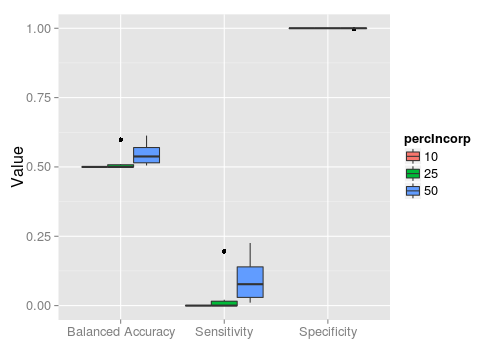

In [58]:
%%R -w 500 -h 350

col2keep = c('Balanced Accuracy', 'Sensitivity','Specificity')

byClass.f = byClass %>%
    filter(X %in% col2keep) %>%
    mutate(percIncorp = as.character(percIncorp))

ggplot(byClass.f, aes(X, byClass, fill=percIncorp)) +
    geom_boxplot(position='dodge') +
    labs(y='Value') +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
        )